# RoBERTa (BERT) vs Logistic Regression
## Overview
This project will be showcasing the steps to build two different emotion detection NLP models (using RoBERTa and Logistic Regression, as the title suggests). We will also be looking at factors such as the spread of the dataset, time for training, and the accuracy of both models. 

## Prerequisites
If you want to run this project on your own machine, make sure to have the following items installed:
\
Python and Jupyter Notebook, Tensorflow, and all Python packages imported below. 
\
The dataset files ('test.txt', 'train.txt', 'val.txt'), which can be found at the link in the "Sources" section at the end of this notebook. Take these files and put them in a subdirectory (called 'data'), relative of the directory of this notebook. 

### Model 1: Logistic Regression
We start by building the simpler model, using logistic regression. Before beginning, we import the needed packages for this first part of making the model. Then, we start by importing the dataset into Pandas DataFrames and combining them into one DataFrame, and then preprocessing the text by running some NeatText functions. Then, we'll use scikit-learn to apply Logisitic Regression. 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
import pickle

In [2]:
# Loading Dataset
df1 = pd.read_csv('./data/test.txt', names=['text', 'emotion'], sep=';')
df2 = pd.read_csv('./data/train.txt', names=['text', 'emotion'], sep=';')
df3 = pd.read_csv('./data/val.txt', names=['text', 'emotion'], sep=';')

In [3]:
df = df1.append(df2,ignore_index=True)

/var/folders/cx/yt63_56d0wd52vm5byxp8c3c0000gn/T/ipykernel_12140/4176271390.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2,ignore_index=True)


In [4]:
df = df.append(df3,ignore_index=True)

/var/folders/cx/yt63_56d0wd52vm5byxp8c3c0000gn/T/ipykernel_12140/3193326270.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df3,ignore_index=True)


In [5]:
# Text Cleaning
df['clean_text'] = df['text'].apply(nfx.remove_stopwords)

In [6]:
df['clean_text'] = df['clean_text'].apply(nfx.remove_userhandles)

In [7]:
df['clean_text'] = df['clean_text'].apply(nfx.remove_punctuations)

In [8]:
# Importing ML Model
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [9]:
# Splitting Dataset
from sklearn.model_selection import train_test_split

In [10]:
x_features = df['clean_text']
y_labels = df['emotion']

In [11]:
# Vectorizer
cv = CountVectorizer()
X = cv.fit_transform(x_features)

In [39]:
x_train,x_test_lr,y_train,y_test_lr = train_test_split(X,y_labels,test_size=0.3,random_state=42)

In [40]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

/Users/harish/programming/emotion-detection/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
lr_model.score(x_test_lr,y_test_lr)

0.885

In [15]:
# Make a prediction
sample_text = ["I'm a bit mad"]

In [16]:
vect = cv.transform(sample_text).toarray()

In [17]:
lr_model.predict(vect)

array(['anger'], dtype=object)

In [18]:
# Saving model and vectorizer
pickle.dump(lr_model, open('lr_model.sav', 'wb'))
pickle.dump(cv, open('vectorizer.pickle', 'wb'))

## Model 2: RoBERTa
We will now following the same series of steps, with changes in our approach, to build a model based off of RoBERTa. 

In [19]:
# Imports
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/harish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
train_data = pd.read_csv('./data/train.txt', names=['text', 'emotion'], sep=';')
val_data = pd.read_csv('./data/val.txt', names=['text', 'emotion'], sep=';')
test_data = pd.read_csv('./data/test.txt', names=['text', 'emotion'], sep=';')

In [21]:
# Checking for null values in the dataset
train_data['emotion'].isnull().sum()
val_data['emotion'].isnull().sum()
test_data['emotion'].isnull().sum()

0

In [22]:
# Pre-Processing
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = re.sub('[^A-z]', ' ', text)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except', 'even though', 'yet']
    stop_words = [word for word in stop_words if word not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in text.split() if temp not in stop_words and temp[0] != "["]
    return ' '.join([x for x in preprocessed_tokens]).strip()

In [23]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
val_data['text'] = val_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))

In [24]:
# Adding repetition to all classes except the highest frequency class
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1,1), np.array(train_data['emotion']).reshape(-1,1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

In [25]:
# Test
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

In [26]:
# Adding OneHotEncoder
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train = le.fit_transform(np.array(train['emotion']).reshape(-1,1)).toarray()
y_test = le.fit_transform(np.array(test_data['emotion']).reshape(-1,1)).toarray()
y_val = le.fit_transform(np.array(val_data['emotion']).reshape(-1,1)).toarray()
y_train

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [27]:
# Encoding
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [28]:
def roberta_encode(data,maximum_length):
    input_ids = []
    attention_masks = []
    
    for i in range(len(data.text)):
        encoded = tokenizer.encode_plus(
            data.text[i],
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [29]:
max_len = max([len(x.split()) for x in train_data['text']])
train_input_ids,train_attention_masks = roberta_encode(train,max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data,max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data,max_len)
type(test_input_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/harish/programming/emotion-detection/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


numpy.ndarray

In [30]:
# Creating Model
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(6,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    #model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.compile(Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [31]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

2023-01-13 13:23:34.744882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-13 13:23:34.745082: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [32]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 43,                                            

In [33]:
# Training Model (I ran 1 epoch for speed reasons, but increase this to 4+ epochs for higher accuracy)
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val),
                   epochs=4,batch_size=100)

Epoch 1/4


2023-01-13 13:23:37.922495: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-13 13:23:43.905974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


322/322 [==============================] - ETA: 0s - loss: 0.9896 - accuracy: 0.6026

2023-01-13 13:30:38.450139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


322/322 [==============================] - 430s 1s/step - loss: 0.9896 - accuracy: 0.6026 - val_loss: 0.3535 - val_accuracy: 0.8870
Epoch 2/4
322/322 [==============================] - 420s 1s/step - loss: 0.2612 - accuracy: 0.9092 - val_loss: 0.2445 - val_accuracy: 0.9230
Epoch 3/4
322/322 [==============================] - 422s 1s/step - loss: 0.1858 - accuracy: 0.9325 - val_loss: 0.2192 - val_accuracy: 0.9290
Epoch 4/4
322/322 [==============================] - 420s 1s/step - loss: 0.1491 - accuracy: 0.9432 - val_loss: 0.1892 - val_accuracy: 0.9335


In [34]:
# Saving Weights
model.save_weights('roberta_emotion_1')

## Comparisons
Now that both models have been created, it is time to compare the two! We will start by looking at training time, then graphing the spread of emotions in the dataset, then plotting accuracy graphs of the model, and finally calculating the F1 scores of the two models and comparing their accuracies. 
\
One factor to consider is training time and resource consumption of the two models. When training the logistic regression model, it only took a matter of seconds, while training four epochs of the RoBERTa-based model took about 26 minutes on my machine. While this is still not a very long time, when using larger datasets, which RoBERTa requires to be more accurate, it can take dozens of hours to train, while logistic regression may just take a higher number of seconds.
\
Similarly, when applying the model, logistic regression is much faster and has a lighter load on the machine, while RoBERTa takes a bit of time. Thus, when developing an application that needs to call on the model frequently and return the result to the user, logistic regression would likely be a better choice. 

<function matplotlib.pyplot.show(close=None, block=None)>

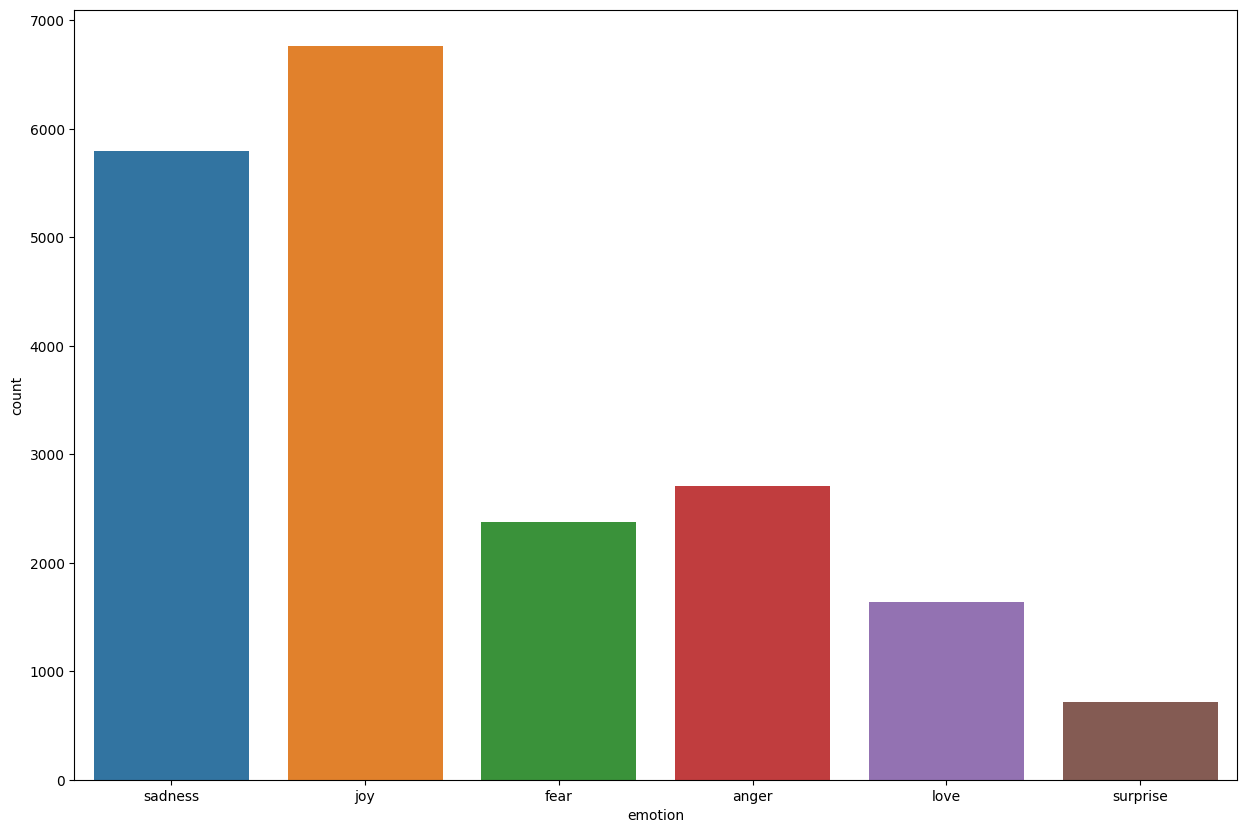

In [35]:
# Plotting graph of dataset spread (number of occurrences of each emotion)
plt.figure(figsize=(15,10))
sns.countplot(x='emotion',data=df)
plt.show

In [36]:
# Accuracy and F1 Score
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)),result.argmax(1)] = 1

2023-01-13 13:51:54.328871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 26s 320ms/step


In [42]:
from sklearn.metrics import accuracy_score, f1_score
accuracy_lr = lr_model.score(x_test_lr,y_test_lr)
accuracy_roberta = accuracy_score(y_test,y_pred)
print('Accuracy of Logistic Regression model', accuracy_lr)
print('Accuracy of RoBERTa model', accuracy_roberta)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score of RoBERTA model:', f1)

Accuracy of Logistic Regression model 0.885
Accuracy of RoBERTa model 0.9245
F1 Score of RoBERTA model: 0.890108061935523


## Conclusion
- RoBERTa is a more complex model, that takes longer to train and use, but results in getting more accurate results. 
- Logistic Regression is faster in both training and applying, but may be a bit less accurate as a tradeoff. 
- Both models have their benefits and drawbacks, and different usecases may govern which one to go with. If you need a really accurate model that you are periodically going to call, RoBERTa is the one to go with. If you need something fast, logistic regression may be the way to go. 

Sources:
\
Dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
\
RoBERTa Model: https://www.kaggle.com/code/dhruv1234/emotion-classification-roberta/notebook